In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('C:\\Users\\joewa\\Work\\git\\vimms')
sys.path.append('C:\\Users\\Vinny\\work\\vimms')
sys.path.append('..')

In [3]:
import numpy as np
import torch
import random as rand
import pylab as plt
import multiprocessing

In [4]:
from vimms.Common import *
from vimms.Gym import FragmentEnv
from vimms.Evaluation import evaluate_simulated_env, evaluate_multiple_simulated_env

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


In [5]:
np.random.seed(0)
rand.seed(0)
torch.manual_seed(0)

### Parameters

In [6]:
set_log_level_warning()

1

In [7]:
n_chemicals = (400, 1000)
mz_range = (100, 600)
rt_range = (0, 500)
intensity_range = (1E5, 1E10)

In [8]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (0, 300)
# intensity_range = (1E5, 1E10)

In [9]:
min_mz = mz_range[0]
max_mz = mz_range[1]
min_rt = rt_range[0]
max_rt = rt_range[1]
min_log_intensity = np.log(intensity_range[0])
max_log_intensity = np.log(intensity_range[1])

In [10]:
isolation_window = 0.7
N = 10
rt_tol = 15
mz_tol = 10
min_ms1_intensity = 5000
ionisation_mode = POSITIVE
noise_density = 0.3
noise_max_val = 1e4

### Custom gym

In [11]:
params = {
    'chemical_creator': {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals
    },
    'noise': {
        'noise_density': noise_density,
        'noise_max_val': noise_max_val,
        'mz_range': mz_range
    },
    'env': {
        'ionisation_mode': ionisation_mode,
        'rt_range': rt_range,
        'N': N,
        'isolation_window': isolation_window,
        'mz_tol': mz_tol,
        'rt_tol': rt_tol,
        'min_ms1_intensity': min_ms1_intensity
    }
}

In [12]:
set_log_level_info()

2

### PPO

In [13]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env

In [14]:
env = FragmentEnv(params)
check_env(env)

 /home/joewandy/.local/share/virtualenvs/vimms-cLOHTDI_/lib/python3.7/site-packages/gym/logger.py:30: UserWarning:WARN: Box bound precision lowered by casting to float32


In [15]:
n_envs = int(multiprocessing.cpu_count() / 2)
n_envs

12

In [16]:
# env = make_vec_env(FragmentEnv, n_envs=n_envs, env_kwargs={'params': params})
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./results/ppo_fragmentenv_tensorboard/")
model.learn(total_timesteps=250000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./results/ppo_fragmentenv_tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 149      |
|    ep_rew_mean     | 2.8e+04  |
| time/              |          |
|    fps             | 6        |
|    iterations      | 1        |
|    time_elapsed    | 319      |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 146          |
|    ep_rew_mean          | 2.61e+04     |
| time/                   |              |
|    fps                  | 6            |
|    iterations           | 2            |
|    time_elapsed         | 610          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0034640292 |
|    clip_fraction        | 0         

In [17]:
model.save('results/ppo_all_chems')

## Evaluation

In [18]:
model = PPO.load('results/ppo_all_chems')

In [19]:
def evaluation(model, num_episodes):
    env = FragmentEnv(params)
    total_rewards = []
    total_reward_per_chems = []
    env_list = []
    
    for i_episode in range(num_episodes):
        observation = env.reset()
        total_reward = 0
        for t in range(1000):
            # env.render()
            if model == 'random':
                action = env.action_space.sample()
                out_file = 'test_%s_%d.mzML' % (model, i_episode)
            elif model == 'TopN':
                action = -1
                out_file = 'test_%s_%d.mzML' % (model, i_episode)                
            else:
                action, _ = model.predict(observation)     
                out_file = 'test_%s_%d.mzML' % ('PPO', i_episode)
                                                
            observation, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                seen_actions = env.seen_actions.most_common()
                n_chems = len(env.chems)
                reward_per_chems = total_reward / n_chems
                print('Episode %d timesteps %d reward %f n_chems %d reward/chems %f actions %s' % (i_episode, t+1, total_reward, n_chems, reward_per_chems, seen_actions))
                total_rewards.append(total_reward)
                total_reward_per_chems.append(reward_per_chems)
                env_list.append(env.vimms_env)
                if i_episode % write_mzml_every == 0 or i_episode == num_episodes-1:
                    env.vimms_env.write_mzML('results', out_file)
                break
    env.close()
    logger.info('Average total reward = %f' % np.mean(total_rewards))
    return np.array(total_rewards), np.array(total_reward_per_chems), env_list

In [20]:
num_episodes = 100
write_mzml_every = 20

### PPO

In [21]:
ppo_total_rewards, ppo_reward_per_chems, ppo_env_list = evaluation(model, num_episodes)

Episode 0 timesteps 96 reward 38909.945134 n_chems 767 reward/chems 50.730046 actions [('N=25', 54), ('DEW=5.0', 38), ('N=10', 2), ('DEW=10.0', 1), ('N=20', 1)]
Episode 1 timesteps 93 reward 34420.882175 n_chems 440 reward/chems 78.229278 actions [('N=25', 47), ('DEW=5.0', 45), ('DEW=15.0', 1)]
Episode 2 timesteps 100 reward 38917.364686 n_chems 774 reward/chems 50.280833 actions [('DEW=5.0', 50), ('N=25', 48), ('N=20', 2)]
Episode 3 timesteps 93 reward 37571.703831 n_chems 584 reward/chems 64.335109 actions [('N=25', 50), ('DEW=5.0', 43)]
Episode 4 timesteps 93 reward 37611.455343 n_chems 749 reward/chems 50.215561 actions [('N=25', 56), ('DEW=5.0', 34), ('DEW=15.0', 1), ('DEW=20.0', 1), ('N=20', 1)]
Episode 5 timesteps 93 reward 37393.238227 n_chems 675 reward/chems 55.397390 actions [('N=25', 51), ('DEW=5.0', 40), ('DEW=15.0', 1), ('N=20', 1)]
Episode 6 timesteps 93 reward 39558.399232 n_chems 897 reward/chems 44.100780 actions [('DEW=5.0', 47), ('N=25', 44), ('DEW=10.0', 1), ('DEW=

2021-05-27 06:17:24.328 | INFO     | __main__:evaluation:36 - Average total reward = 37746.182078


### Random

In [22]:
random_total_rewards, random_reward_per_chems, random_env_list = evaluation('random', num_episodes)

Episode 0 timesteps 138 reward 33482.208341 n_chems 961 reward/chems 34.841008 actions [('DEW=5.0', 21), ('N=20', 16), ('DEW=20.0', 15), ('N=25', 14), ('DEW=15.0', 14), ('N=5', 13), ('N=15', 12), ('DEW=25.0', 12), ('N=10', 11), ('DEW=10.0', 10)]
Episode 1 timesteps 163 reward 30660.948102 n_chems 824 reward/chems 37.209888 actions [('N=10', 23), ('DEW=5.0', 22), ('N=5', 19), ('DEW=10.0', 16), ('DEW=25.0', 16), ('DEW=15.0', 16), ('N=15', 15), ('N=20', 14), ('DEW=20.0', 12), ('N=25', 10)]
Episode 2 timesteps 153 reward 33246.956117 n_chems 893 reward/chems 37.230634 actions [('DEW=20.0', 23), ('DEW=5.0', 22), ('N=20', 18), ('N=15', 15), ('DEW=10.0', 15), ('DEW=15.0', 15), ('DEW=25.0', 13), ('N=5', 12), ('N=25', 10), ('N=10', 10)]
Episode 3 timesteps 145 reward 30196.421962 n_chems 783 reward/chems 38.565034 actions [('DEW=5.0', 18), ('N=25', 16), ('N=15', 15), ('DEW=15.0', 14), ('DEW=10.0', 14), ('DEW=20.0', 14), ('N=5', 14), ('N=10', 14), ('N=20', 13), ('DEW=25.0', 13)]
Episode 4 timest

2021-05-27 06:52:19.513 | INFO     | __main__:evaluation:36 - Average total reward = 24399.000183


### TopN

In [23]:
topN_total_rewards, topN_reward_per_chems, topN_env_list = evaluation('TopN', num_episodes)

Episode 0 timesteps 209 reward 14504.371366 n_chems 470 reward/chems 30.860365 actions [('N=10', 209), ('DEW=15.0', 209)]
Episode 1 timesteps 209 reward 25236.431883 n_chems 671 reward/chems 37.610182 actions [('N=10', 209), ('DEW=15.0', 209)]
Episode 2 timesteps 209 reward 28427.474740 n_chems 851 reward/chems 33.404788 actions [('N=10', 209), ('DEW=15.0', 209)]
Episode 3 timesteps 209 reward 27336.227385 n_chems 734 reward/chems 37.242817 actions [('N=10', 209), ('DEW=15.0', 209)]
Episode 4 timesteps 209 reward 27768.856515 n_chems 785 reward/chems 35.374340 actions [('N=10', 209), ('DEW=15.0', 209)]
Episode 5 timesteps 209 reward 30655.191737 n_chems 924 reward/chems 33.176614 actions [('N=10', 209), ('DEW=15.0', 209)]
Episode 6 timesteps 209 reward 13873.856292 n_chems 452 reward/chems 30.694372 actions [('N=10', 209), ('DEW=15.0', 209)]
Episode 7 timesteps 209 reward 27074.315445 n_chems 752 reward/chems 36.003079 actions [('N=10', 209), ('DEW=15.0', 209)]
Episode 8 timesteps 209 

2021-05-27 07:30:33.321 | INFO     | __main__:evaluation:36 - Average total reward = 24656.235327


### Plots

In [24]:
def plot_diff(controller_names, scores_list, ref_name, ref_scores):
    for controller_name, scores in zip(controller_names, scores_list):
        diff = scores - ref_scores
        perc = np.multiply(diff, 1/ref_scores) * 100
        plt.plot(diff, label=controller_name)
    plt.title('Score improvement over %s' % ref_name)
    plt.ylabel('Score Improvement (%)')
    plt.xlabel('Episode')        
    plt.legend()

def plot_arr(controller_names, arr_list, title):
    for controller_name, arr in zip(controller_names, arr_list):
        plt.plot(arr, label=controller_name)
    plt.title('%s per Episode' % title)
    plt.ylabel(title)
    plt.xlabel('Episode')        
    plt.legend()
        
def get_scores(env_list):
    scores = []
    for env in env_list:
        score = get_score(env)
        scores.append(score)
    return np.array(scores)

def get_score(env):
    res = evaluate_simulated_env(env)
    score = res['coverage_proportion'] * res['intensity_proportion']
    return score

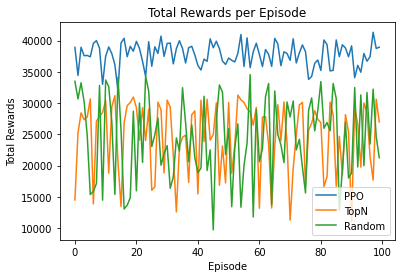

In [25]:
plot_arr(['PPO', 'TopN', 'Random'], [ppo_total_rewards, topN_total_rewards, random_total_rewards], 'Total Rewards')

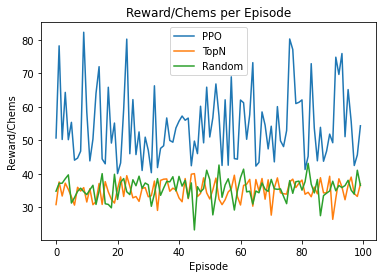

In [26]:
plot_arr(['PPO', 'TopN', 'Random'], [ppo_reward_per_chems, topN_reward_per_chems, random_reward_per_chems], 'Reward/Chems')

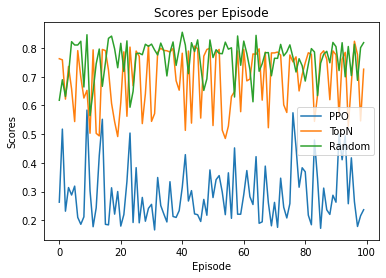

In [27]:
ppo_scores = get_scores(ppo_env_list)
topN_scores = get_scores(topN_env_list)
random_scores = get_scores(random_env_list)
plot_arr(['PPO', 'TopN', 'Random'], [ppo_scores, topN_scores, random_scores], 'Scores')

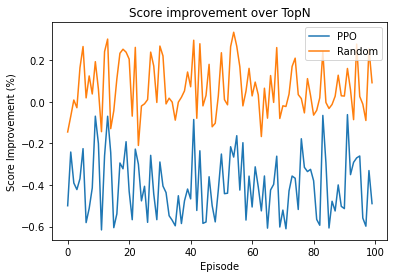

In [28]:
plot_diff(['PPO', 'Random'], [ppo_scores, random_scores], 'TopN', topN_scores)